<a href="https://colab.research.google.com/github/Chenchu-906/Big-Data/blob/main/YOLO_BDJcomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yolo 3

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession  #Connect spark code on top of spark engine
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [3]:
import pyspark
from pyspark import SparkConf
from pyspark.context import SparkContext 

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sc

<SparkContext master=local[4] appName=pyspark-shell>

In [4]:
import cv2 as cv
import numpy as np
import time
from google.colab.patches import cv2_imshow

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [7]:
import gdown

In [8]:
!gdown --fuzzy https://drive.google.com/file/d/1zH_nGTAl_LZJROASyZodhqk-0oP6_4qI/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=1zH_nGTAl_LZJROASyZodhqk-0oP6_4qI
To: /content/yolov3.cfg
100% 8.34k/8.34k [00:00<00:00, 4.03MB/s]


In [9]:
!gdown --fuzzy https://drive.google.com/file/d/1IZscIUKTJLZKLADWvmY-GtR90-1rXh74/view?usp=share_link

Downloading...
From (uriginal): https://drive.google.com/uc?id=1IZscIUKTJLZKLADWvmY-GtR90-1rXh74
From (redirected): https://drive.google.com/uc?id=1IZscIUKTJLZKLADWvmY-GtR90-1rXh74&confirm=t&uuid=b3647af2-92bc-4b76-a2a1-dd38f5496048
To: /content/yolov3.weights
100% 248M/248M [00:07<00:00, 32.3MB/s]


In [10]:
!gdown --fuzzy https://drive.google.com/file/d/1wCI1LpoyoicGZdsk41Ag6JZYoLuuqRlM/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=1wCI1LpoyoicGZdsk41Ag6JZYoLuuqRlM
To: /content/coco.names
100% 621/621 [00:00<00:00, 1.15MB/s]


In [11]:
# importing dependencies

import cv2 as cv
import numpy as np
import time
from google.colab.patches import cv2_imshow

In [12]:
# Give the configuration and weight files for the model and load the network.
net = cv.dnn.readNetFromDarknet('/content/yolov3.cfg' , '/content/yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)


In [13]:
#load model layers

ln = sc.parallelize(net.getLayerNames())
#print(len(ln), ln)

num_layers = ln.map(lambda layers: layers[0]).count()
print("No of layers in the model: ",num_layers)

No of layers in the model:  254


In [14]:
# Load names of classes

classes = sc.textFile('/content/coco.names')
class_labels = classes.map(lambda line: line.split(","))
print("Example labels: " ,class_labels.take(10))
num_classes = classes.map(lambda labels: labels[0]).count()
print("No of classes the model can predict: ",num_classes)

#Getting colors
np.random.seed(42)
colors = np.random.randint(0, 255, size=(num_classes, 3), dtype='uint8')

Example labels:  [['person'], ['bicycle'], ['car'], ['motorcycle'], ['airplane'], ['bus'], ['train'], ['truck'], ['boat'], ['traffic light']]
No of classes the model can predict:  80


In [16]:
# Load images

df = spark.read.format("image").option("dropInvalid", True).load("/content/gdrive/MyDrive/camera-20230304T144555Z-001/camera/F_MIDLONGRANGECAM_CL/F_MIDLONGRANGECAM_CL_0051560.jpg")
df.select("image.origin", "image.width", "image.height").show(truncate=False)


+-----------------------------------------------------------------------------------------------------------------------+-----+------+
|origin                                                                                                                 |width|height|
+-----------------------------------------------------------------------------------------------------------------------+-----+------+
|file:///content/gdrive/MyDrive/camera-20230304T144555Z-001/camera/F_MIDLONGRANGECAM_CL/F_MIDLONGRANGECAM_CL_0051560.jpg|1280 |704   |
+-----------------------------------------------------------------------------------------------------------------------+-----+------+



In [17]:

df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



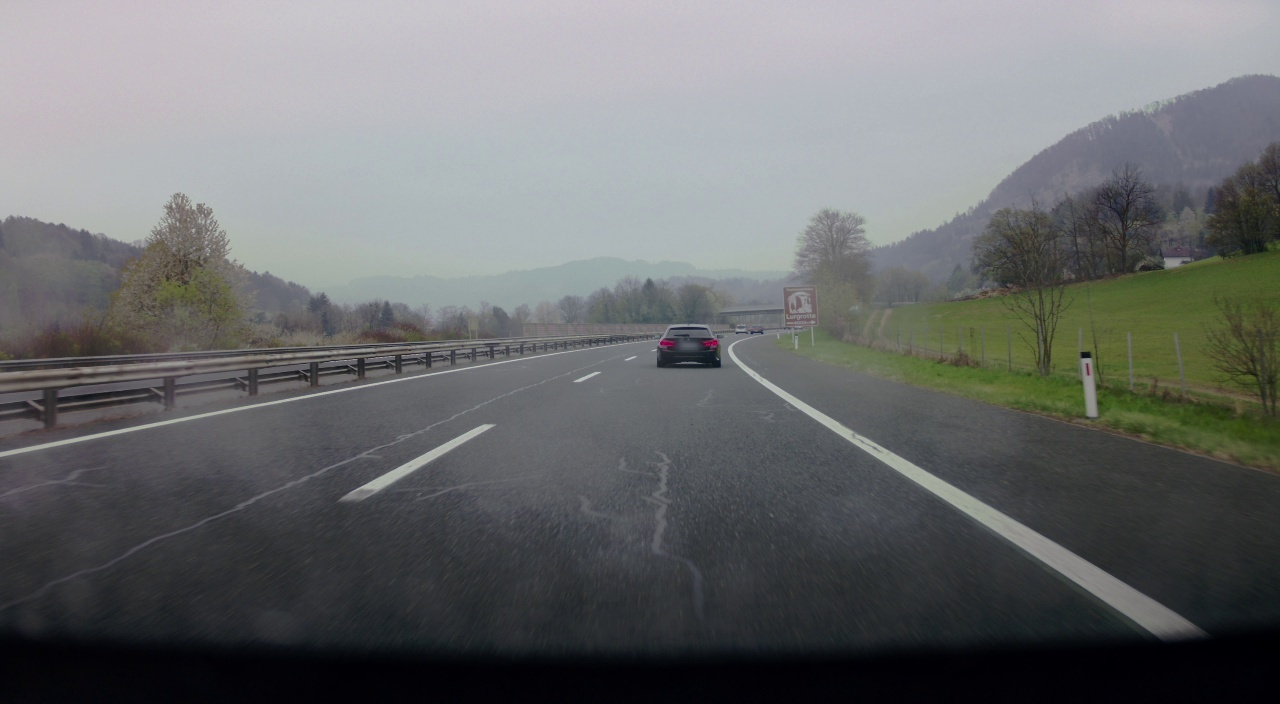

In [19]:

img = cv.imread("/content/gdrive/MyDrive/camera-20230304T144555Z-001/camera/F_MIDLONGRANGECAM_CL/F_MIDLONGRANGECAM_CL_0051560.jpg")
cv2_imshow(img)
imgtemp=img.copy()

In [20]:
unconnected = net.getUnconnectedOutLayers()
ln = ln.zipWithIndex().filter(lambda x: x[1]+1 in unconnected).map(lambda x: x[0])


In [21]:
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]
print(r.shape)

(416, 416)


In [22]:
net.setInput(blob)
outputs = net.forward(ln.collect())

In [23]:
print('outputs length',len(outputs))
for out in outputs:
    print('out shape',out.shape)
    #print(out)

outputs length 3
out shape (507, 85)
out shape (2028, 85)
out shape (8112, 85)


height: 1280 width: 704


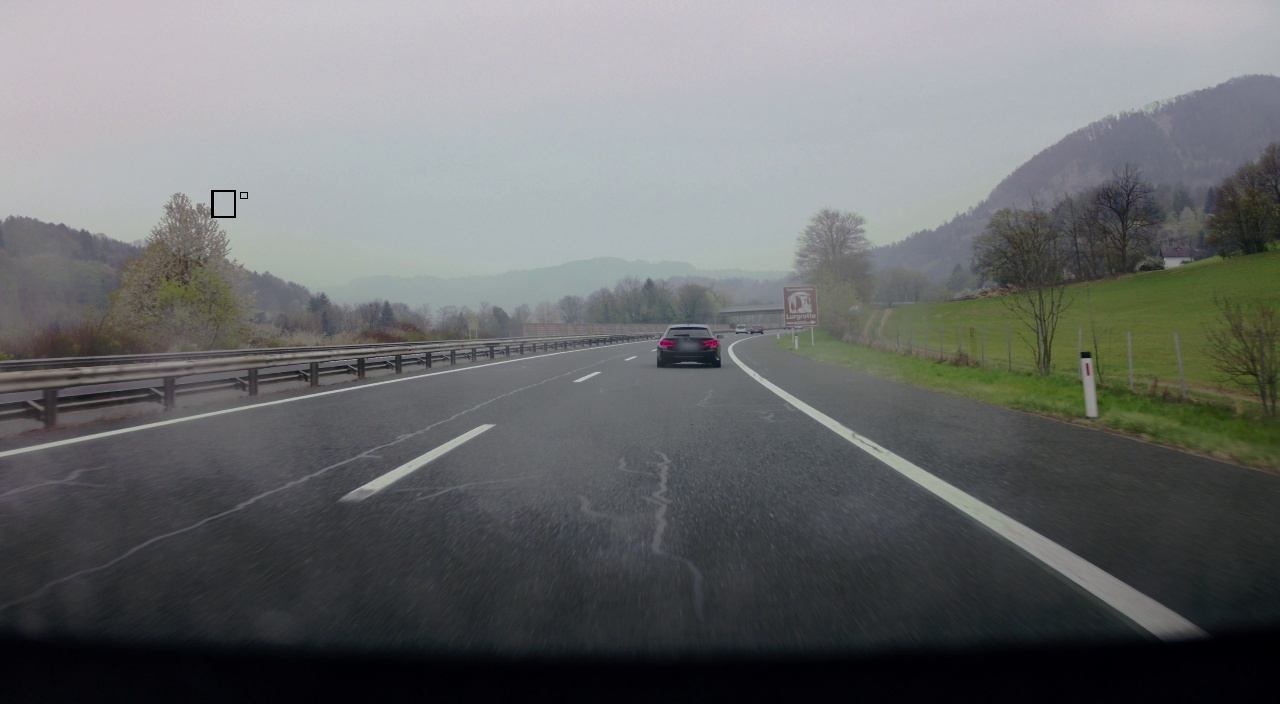

height: 704 width: 1280
score threshold 0.8 nms Threshold 0.5


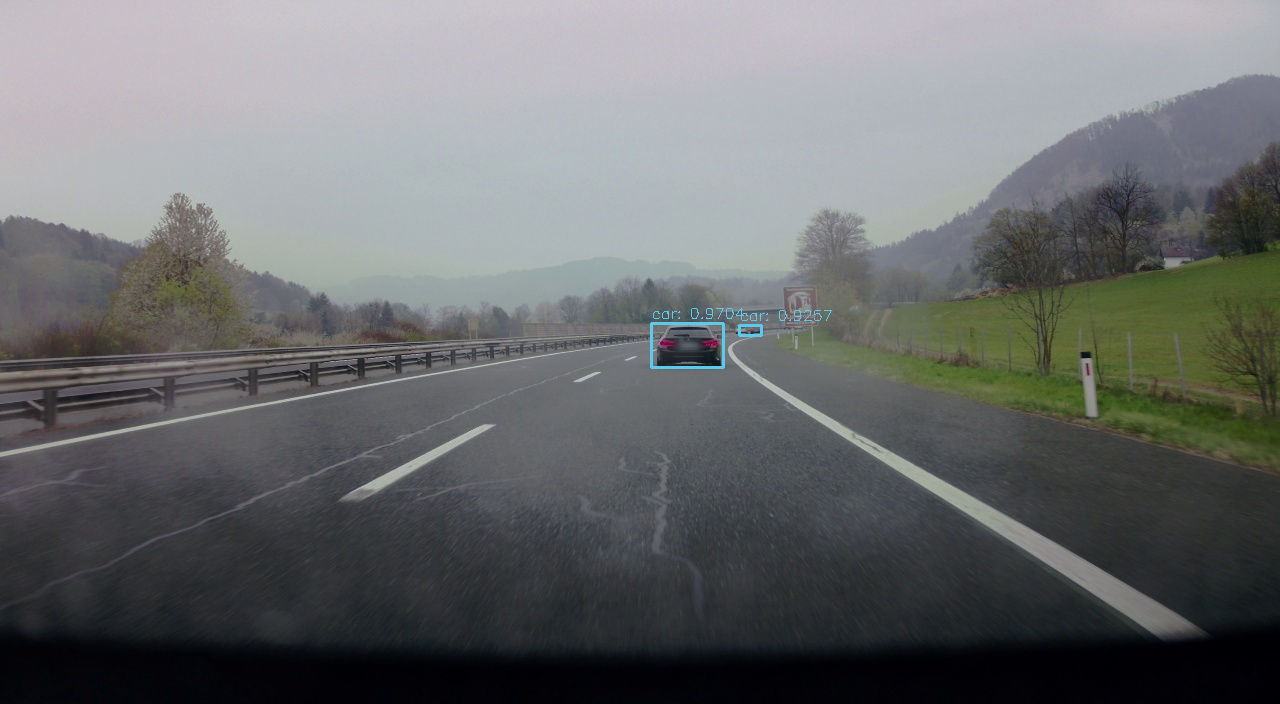

In [24]:
CON = 0.7
def trackbar2(x):
    confidence = x/100
    r = r0.copy()
    for output in np.vstack(outputs):
        if output[4] > confidence:
            #print(output[:4])
            x, y, w, h = output[:4]
            p0 = int((x-w/2)*416), int((y-h/2)*416)
            p1 = int((x+w/2)*416), int((y+h/2)*416)
            cv.rectangle(r, p0, p1, 1, 1)
            cv.rectangle(imgtemp,p0, p1, 1, 1)
    w1,h1=imgtemp.shape[:2]
    print("height:",h1,"width:",w1)
    cv2_imshow(imgtemp)
        
    
r0 = blob[0, 0, :, :]
r = r0.copy()
trackbar2(CON*100)

boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]
print("height:",h,"width:",w)
for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > CON:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

#score_threshold=0.5
#nms_threshold=0.4

score_threshold=0.8
nms_threshold=0.5

print("score threshold",score_threshold,"nms Threshold",nms_threshold)
#0.5  0.4
indices = cv.dnn.NMSBoxes(boxes, confidences, score_threshold, nms_threshold)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classes.collect()[classIDs[i]], confidences[i])
        cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)


cv2_imshow(img)

